<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Conv/LeNet_5_on_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LeNet-5 CIFAR-10 Classifier

Using the classic LeNet-5 architecture on CIFAR 10 dataset

### Imports

In [1]:
import os
import time 

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Model Settings 

In [2]:
## Settings  

RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# other 
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = 'cpu'

GRAYSCALE = False

## CIFAR-10 Dataset

In [3]:
train_mean = (0.5, 0.5, 0.5)
train_std = (0.5, 0.5, 0.5)

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=train_mean, std=train_std)])

## note: transforms.ToTensor() scales imput to images
## to 0-1 range

train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 transform=resize_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                transform=resize_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=8)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=8)

## checking dataset

for images, label in train_loader:
    print('Image batch dimensions: ', images.size())
    print('Target batch dimensions: ', label.size())
    break

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions:  torch.Size([128, 3, 32, 32])
Target batch dimensions:  torch.Size([128])


In [6]:
## testing the dataloader

device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):
    for batch_id, (images, labels) in enumerate(train_loader):

        print(f"Epoch: {epoch + 1:03d}", end="")
        print(f"  |  Batch no: {batch_id + 1:03d}", end="")
        print(f"  |  Batch size: {images.size(0):03d}")

        images.to(device)
        labels.to(device)
        break


Epoch: 001  |  Batch no: 001  |  Batch size: 128
Epoch: 002  |  Batch no: 001  |  Batch size: 128


In [10]:
# Model

class LeNet(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*in_channels*5*5, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes) 
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = nn.Softmax(dim=1)(logits)
        return logits, probas

In [20]:
torch.manual_seed(RANDOM_SEED)

model = LeNet(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [21]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, labels) in enumerate(data_loader):

        features = features.to(device)
        labels = labels.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += labels.size(0)
        correct_pred += (predicted_labels.float() == labels.float()).sum()
    return (correct_pred / num_examples) * 100

start_time = time.time()

for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        features = features.to(device)
        labels = labels.to(device)

        ## forward and backprop
        logits, probas = model(features)
        cost = F.cross_entropy(logits, labels)
        optimizer.zero_grad()

        cost.backward()

        ## update model
        optimizer.step()

        ## logging 
        if not batch_idx % 50:
            print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Batch: {batch_idx:04d}/{len(train_loader)}"
                  f" | Cost: {cost:.4f}")
        
    model.eval()
    with torch.set_grad_enabled(False):
        print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | "
              f"Train Acc: {compute_accuracy(model, train_loader, device=DEVICE):.3f}")
    print(f"Time elapsed: {(start_time - time.time()) / 60:.02f} min")

print(f"Total time elapsed: {(start_time - time.time()) / 60:.02f} min")

Epoch: 001/010 | Batch: 0000/391 | Cost: 2.3064
Epoch: 001/010 | Batch: 0050/391 | Cost: 1.6938
Epoch: 001/010 | Batch: 0100/391 | Cost: 1.4411
Epoch: 001/010 | Batch: 0150/391 | Cost: 1.5975
Epoch: 001/010 | Batch: 0200/391 | Cost: 1.3475
Epoch: 001/010 | Batch: 0250/391 | Cost: 1.2794
Epoch: 001/010 | Batch: 0300/391 | Cost: 1.3810
Epoch: 001/010 | Batch: 0350/391 | Cost: 1.3520
Epoch: 001/010 | Train Acc: 57.460
Time elapsed: -0.36 min
Epoch: 002/010 | Batch: 0000/391 | Cost: 1.3358
Epoch: 002/010 | Batch: 0050/391 | Cost: 1.2924
Epoch: 002/010 | Batch: 0100/391 | Cost: 1.1840
Epoch: 002/010 | Batch: 0150/391 | Cost: 1.0060
Epoch: 002/010 | Batch: 0200/391 | Cost: 1.1809
Epoch: 002/010 | Batch: 0250/391 | Cost: 1.5567
Epoch: 002/010 | Batch: 0300/391 | Cost: 0.8161
Epoch: 002/010 | Batch: 0350/391 | Cost: 1.0530
Epoch: 002/010 | Train Acc: 63.858
Time elapsed: -0.72 min
Epoch: 003/010 | Batch: 0000/391 | Cost: 1.0128
Epoch: 003/010 | Batch: 0050/391 | Cost: 1.0955
Epoch: 003/010 | B

## Evaluation

In [22]:
with torch.set_grad_enabled(False):
    print(f"Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f} %")

Test accuracy: 67.41 %


In [24]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """ 
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized

        RETURNS:
        ---------
        Tensor: Normalized image.

        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean = train_mean, std=train_std)

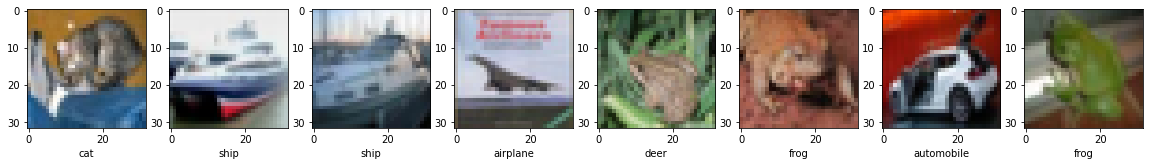

In [31]:
for features, targets in test_loader:
    break

_, predictions = model(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'airplane',
     1: 'automobile',
     2: 'bird',
     3: 'cat',
     4: 'deer',
     5: 'dog',
     6: 'frog',
     7: 'horse',
     8: 'ship',
     9: 'truck'}

fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()